In [1]:
import numpy as np
# import cupy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
img_size = 8
n_in_out = img_size * img_size
n_mid = 16

eta = 0.01
epochs = 41
batch_size = 32
interval = 4

In [3]:
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 15

In [4]:
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2 / n_upper) # He init
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) 
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1 / (1 + np.exp(-u)) # sigmoid
        
    def backward(self, t):
        delta = (self.y - t) * self.y * (1 - self.y)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

In [5]:
middle_layer = MiddleLayer(n_in_out, n_mid) # Encoder
output_layer = OutputLayer(n_mid, n_in_out) # Decoder

In [6]:
def forward_propagation(x_mb):
    middle_layer.forward(x_mb)
    output_layer.forward(middle_layer.y)
    
def backward_propagation(t_mb):
    output_layer.backward(t_mb)
    middle_layer.backward(output_layer.grad_x)
    
def update_params():
    middle_layer.update(eta)
    output_layer.update(eta)
    
def get_error(y, t):
    return 1.0 / 2.0 * np.sum(np.square(y - t)) # MSE

Epoch:1/41 Error:3123.9991996701756
Epoch:5/41 Error:1581.6870764294188
Epoch:9/41 Error:1179.3503349645957
Epoch:13/41 Error:987.2718458211199
Epoch:17/41 Error:861.6308998164047
Epoch:21/41 Error:831.1978644513536
Epoch:25/41 Error:801.2268031110473
Epoch:29/41 Error:776.794670265431
Epoch:33/41 Error:741.5722749318301
Epoch:37/41 Error:705.3560238338679
Epoch:41/41 Error:675.0572561805736


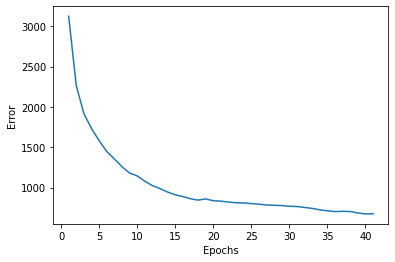

In [7]:
error_record = []
n_batch = len(x_train) // batch_size

for i in range(epochs):
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j * batch_size : (j + 1) * batch_size]
        x_mb = x_train[mb_index, :]
        
        forward_propagation(x_mb)
        backward_propagation(x_mb)
        
        update_params()
    
    forward_propagation(x_train)
    error = get_error(output_layer.y, x_train)
    error_record.append(error)
    
    if i % interval == 0:
        print("Epoch:" + str(i + 1) + "/" + str(epochs), "Error:" + str(error))
        
plt.plot(range(1, len(error_record ) + 1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

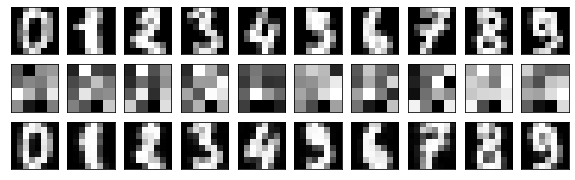

In [8]:
n_img = 10
middle_layer.forward(x_train[:n_img])
output_layer.forward(middle_layer.y)

plt.figure(figsize=(10, 3))
for i in range(n_img):
    ax = plt.subplot(3, n_img, i + 1)
    plt.imshow(x_train[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i + 1 + n_img)
    plt.imshow(middle_layer.y[i].reshape(4, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n_img, i + 1 + 2 * n_img)
    plt.imshow(output_layer.y[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()